# **Task 3: Post-Training Quantization with SmoothQuant**

## **Overview**
Implements and evaluates **SmoothQuant**, an advanced **post-training quantization (PTQ)** method for large language models.  
The notebook diagnoses why naive quantization struggles, applies activation/weight smoothing, and measures the impact using **Perplexity (PPL)** on the **Wikitext** dataset.

---

## **Step 1: Environment and Data Preparation**

- **Baseline model:**  
  Load a full-precision **BF16** model as the gold-standard reference.

- **Dataset split:**  
  Load **Wikitext** and create two subsets:
  - **Calibration:** A small portion of the training set used to analyze activations and compute SmoothQuant scaling factors.  
  - **Evaluation:** The test set held out for fair PPL evaluation.

---

## **Step 2: Diagnosing the Quantization Challenge**

- **Activation capture:**  
  Use **forward hooks** to record input activations of selected linear layers on calibration batches.

- **Distribution plots:**  
  For each target layer, show side-by-side histograms of  
  (a) **weights** and  
  (b) **input activations**  
  to illustrate why standard quantization is difficult.

---

## **Step 3: Implementing the SmoothQuant Toolkit**

- **Basic quantizers:**  
  Implement **per-channel weight quantization (int8)** and **per-token activation quantization (int8)**.

- **Quantized layer:**  
  Define **`WnAnLinear`**, a drop-in `nn.Linear` replacement that stores quantized weights and dynamically quantizes activations in its forward pass.

- **Smoothing core:**  
  Implement **`smooth_ln_fcs`**, which scales activations down and weights up using factors derived from their distributions—shifting quantization difficulty from activations to weights.

- **Model wrappers:**  
  - **`smooth_model`** applies smoothing across the model.  
  - **`quantize_model`** replaces eligible linear layers with the quantized variant.

---

## **Step 4: Calibration and Evaluation Workflow**

- **Activation scaling:**  
  **`get_act_scales`** runs the calibration set with hooks to compute per-channel activation maxima for smoothing.

- **Perplexity evaluator:**  
  **`Evaluator`** tokenizes data, computes loss, and reports **PPL** (lower is better) on the **Wikitext** test set.

---

## **Step 5: Main Experiments**

- **Configurations:**  
  For example define runs for:
  - **BF16 baseline**
  - **Naive W8A8**
  - **W8A8 + SmoothQuant**

- **Orchestration:**  
  **`run_experiment`** loads the model, optionally smooths, quantizes, and evaluates PPL.

- **Models:**  
  Execute across multiple LLMs (e.g., **Llama-3-8B** and **Llama-2-7B**) and record results.

---

## **Step 6: Results and Conclusions**

- **Aggregation:**  
  Collect PPLs into a **pandas DataFrame** and print a concise summary table to compare **SmoothQuant**, **naive W8A8**, and the **BF16 baseline**.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### Cell 2: Environment Setup and Dependency Installation
import os
import random
import time
from functools import partial
from typing import Optional, Tuple, Callable
import types

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from scipy.stats import linregress
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.generation.stopping_criteria import (
    StoppingCriteria,
    StoppingCriteriaList,
)
from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS
from transformers.models.llama.modeling_llama import (
    LlamaAttention,
    rotate_half,
    repeat_kv,
)
from transformers.utils import logging

BASE_DIR = "./task3_experiments"
RESULTS_DIR = os.path.join(BASE_DIR, "results")
FIGURES_DIR = os.path.join(BASE_DIR, "figures")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    # TODO: Optionally log GPU diagnostics here.
else:
    DEVICE = torch.device("cpu")
    # TODO: Optionally log CPU fallback diagnostics here.

def set_seed(seed=42):
    """Set random seeds for reproducibility across Python, NumPy, and PyTorch."""
    # TODO: Implement reproducibility setup.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For deterministic behavior (slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("\n   Environment setup and dependency installation complete.")



   Environment setup and dependency installation complete.


In [3]:
# ### Cell 3: Hugging Face Login
from huggingface_hub import login, HfFolder
from getpass import getpass

# # Check if a Hugging Face token is already set in the environment.
if not os.getenv("HUGGING_FACE_HUB_TOKEN"):
    try:
        # Prompt user for Hugging Face access token if not found.
        hf_token = getpass("Please enter your Hugging Face access token: ")
        login(token=hf_token, add_to_git_credential=True)
        print("   Hugging Face login successful!")
    except Exception as e:
        print(f"Login failed: {e}. Model loading may fail later.")
else:
    print("   Hugging Face token detected.")

Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
   Hugging Face login successful!


In [22]:
### Cell 4: Model, Tokenizer, and Dataset Loading
MODEL_ID = "meta-llama/Llama-2-7b-hf" # "meta-llama/Meta-Llama-3-8B"

def load_model_and_tokenizer(model_id):
    """
    Loads a specified Hugging Face model and its tokenizer in bfloat16 precision.
    """
    # TODO: Load model and tokenizer for the provided identifier.
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    if tokenizer.pad_token is None:
      tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")
    return model, tokenizer

# Task 3, Step 1: Load the baseline BF16 model for quantization experiments
print("\nLoading bf16 model...")
model_fp16, tokenizer = load_model_and_tokenizer(MODEL_ID)

# Task 3, Step 1: Load the Wikitext dataset for calibration and evaluation
print("\nLoading Wikitext dataset...")
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
calibration_dataset = dataset["train"].select(range(128))  # TODO: Prepare calibration dataset
eval_dataset = dataset["test"]  # TODO: Prepare evaluation dataset
print("   Dataset loaded successfully.")



Loading bf16 model...


Loading checkpoint shards: 100%|██████████| 2/2 [01:12<00:00, 36.41s/it]



Loading Wikitext dataset...
   Dataset loaded successfully.


In [23]:
print(model_fp16)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_e

In [24]:
for name, module in model_fp16.named_modules():
    if isinstance(module, torch.nn.Linear):
      if hasattr(module, "weight"):
        print(f"Layer Name: {name} | Is Meta: {module.weight.is_meta}")


Layer Name: model.layers.0.self_attn.q_proj | Is Meta: False
Layer Name: model.layers.0.self_attn.k_proj | Is Meta: False
Layer Name: model.layers.0.self_attn.v_proj | Is Meta: False
Layer Name: model.layers.0.self_attn.o_proj | Is Meta: False
Layer Name: model.layers.0.mlp.gate_proj | Is Meta: False
Layer Name: model.layers.0.mlp.up_proj | Is Meta: False
Layer Name: model.layers.0.mlp.down_proj | Is Meta: False
Layer Name: model.layers.1.self_attn.q_proj | Is Meta: False
Layer Name: model.layers.1.self_attn.k_proj | Is Meta: False
Layer Name: model.layers.1.self_attn.v_proj | Is Meta: False
Layer Name: model.layers.1.self_attn.o_proj | Is Meta: False
Layer Name: model.layers.1.mlp.gate_proj | Is Meta: False
Layer Name: model.layers.1.mlp.up_proj | Is Meta: False
Layer Name: model.layers.1.mlp.down_proj | Is Meta: False
Layer Name: model.layers.2.self_attn.q_proj | Is Meta: False
Layer Name: model.layers.2.self_attn.k_proj | Is Meta: False
Layer Name: model.layers.2.self_attn.v_proj | 

In [25]:
print(f"model_fp16 device: {next(model_fp16.parameters()).device}")

model_fp16 device: cuda:0


Saved visualization to ./task3_experiments/figures/meta-llama_Llama-2-7b-hf/weight_activation_distributions.png


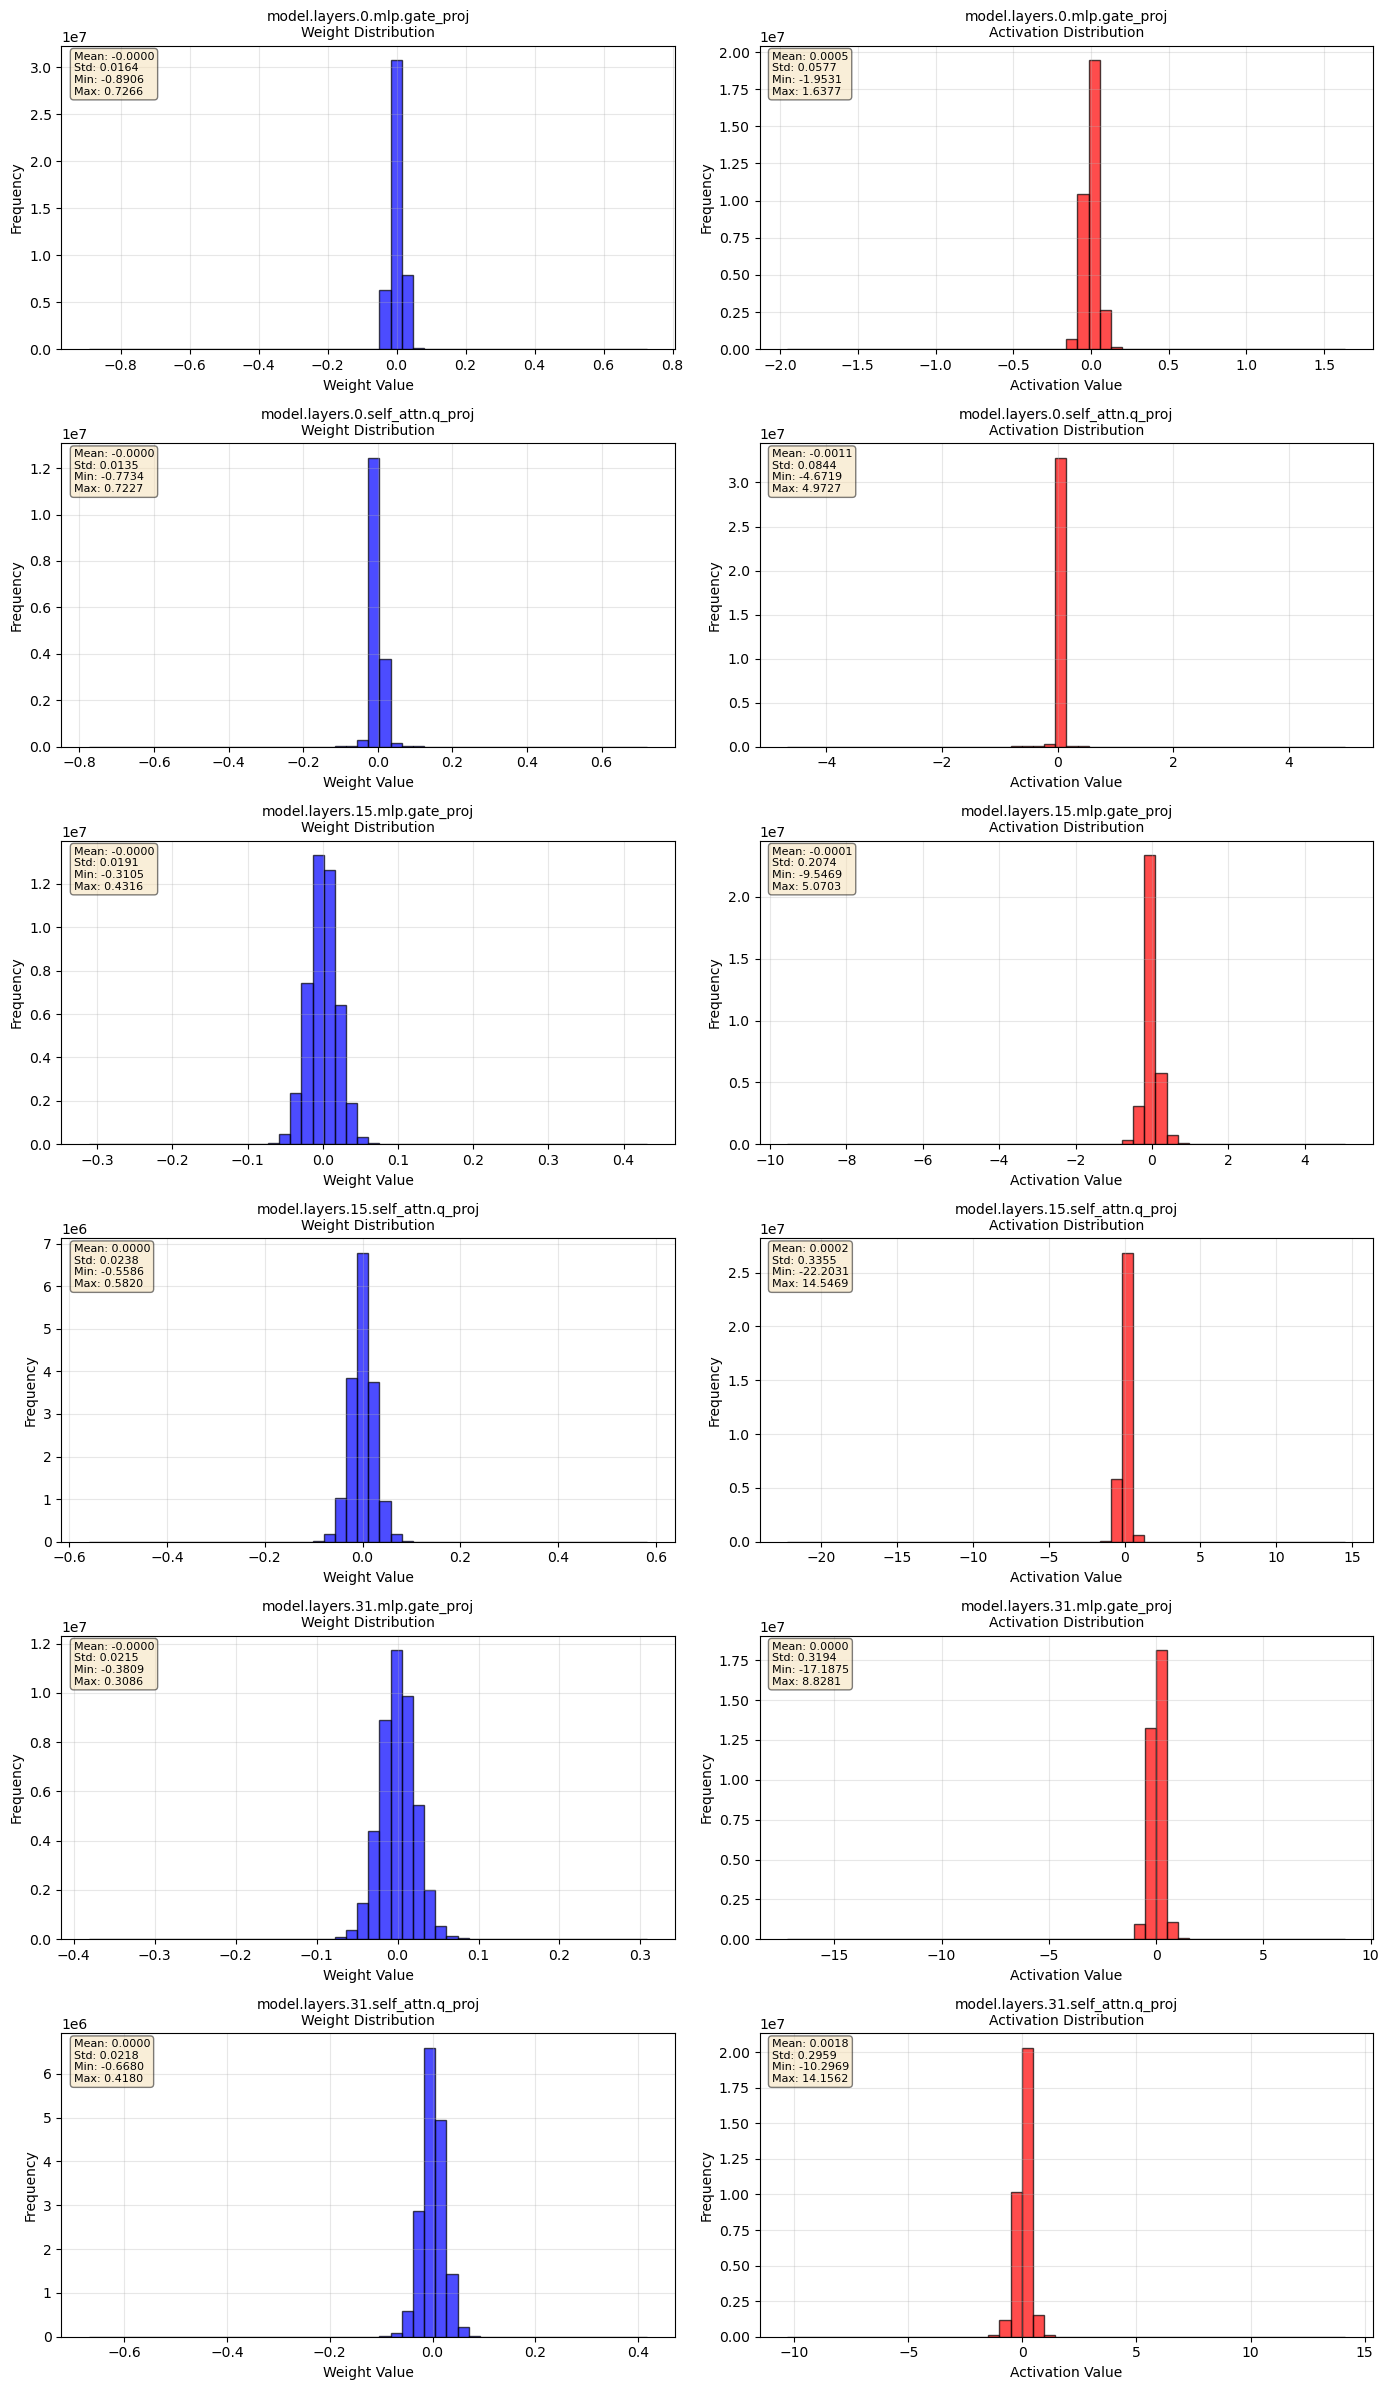

Saved 3D visualization to ./task3_experiments/figures/meta-llama_Llama-2-7b-hf/activations_3d_surface.png


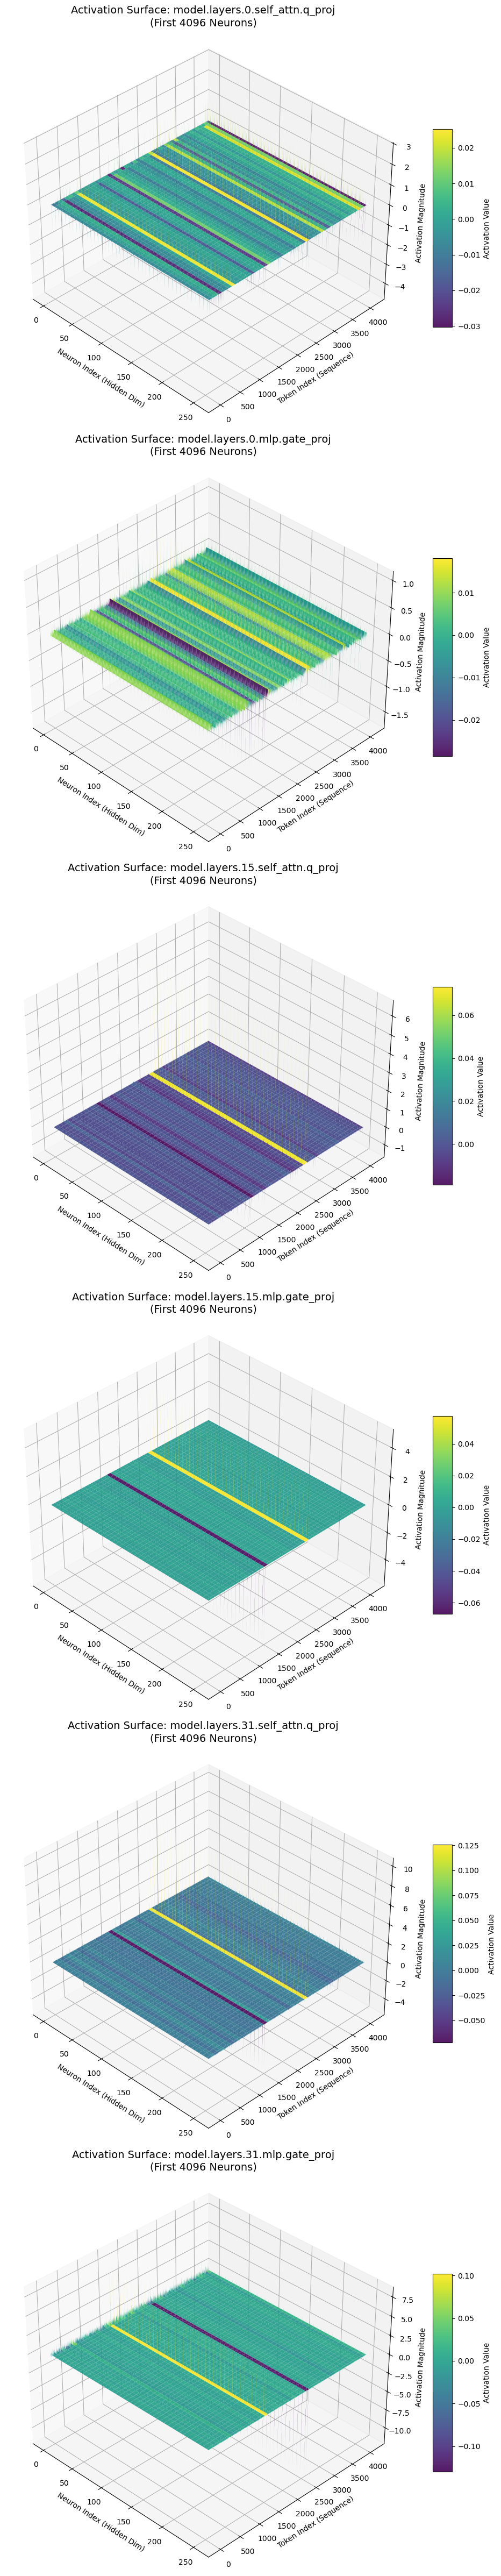

'\nWeight and Activation Distribution Analysis\n\nTODO: Summarize observed phenomena and conclusions after completing the visualizations.\n'

In [26]:
### Cell 5: Visualization of Weight and Activation Distributions

from collections import defaultdict

def collect_layer_activations(model, tokenizer, layer_names, dataset, num_samples=32, seq_len=256, device='cuda'):
    """
    Helper: Runs inference and collects input activations for specified layers.
    Returns: dict {layer_name: list of numpy arrays (Batch, Seq, Hidden)}
    """
    activation_storage = defaultdict(list)

    def get_activation_hook(name):
        def hook(module, input, output):
            # Capture input[0], move to CPU, convert to numpy
            act = input[0].detach().cpu().numpy()
            activation_storage[name].append(act)
        return hook

    # Register hooks
    hooks = []
    layer_name_to_module = dict(model.named_modules())
    
    for name in layer_names:
        if name in layer_name_to_module:
            module = layer_name_to_module[name]
            hooks.append(module.register_forward_hook(get_activation_hook(name)))
        else:
            print(f"Warning: Layer {name} not found.")

    # Run Inference
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            # Handle list of dicts or list of strings
            text = dataset[i]["text"] if isinstance(dataset[i], dict) else dataset[i]
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=seq_len, padding="max_length").to(device)
            model(**inputs)

    # Cleanup
    for hook in hooks:
        hook.remove()

    return activation_storage, layer_name_to_module

def visualize_distributions(model, tokenizer):
    """
    Visualizes the distribution of weights and input activations for selected layers.
    """
    CALIBRATION_SAMPLES = 32  # TODO: Choose number of calibration samples
    SEQ_LEN = 256  # TODO: Choose calibration sequence length
    NUM_BINS = 50  # TODO: Choose number of histogram bins
    LAYERS_TO_VISUALIZE = [
        f"model.layers.{i}.{layer_name}"
        for i in [0, 15, 31]
        for layer_name in ["mlp.gate_proj", "self_attn.q_proj"]
    ]
    # TODO: Collect activations and plot distributions.
    # activation_storage = defaultdict(list)

    activation_storage, layer_name_to_module = collect_layer_activations(
      model, tokenizer, LAYERS_TO_VISUALIZE, calibration_dataset, num_samples=CALIBRATION_SAMPLES, seq_len=SEQ_LEN, device=DEVICE
    )

    weight_dists = {}
    for layer_name in LAYERS_TO_VISUALIZE:
      if layer_name in layer_name_to_module:
        module = layer_name_to_module[layer_name]
        if hasattr(module, "weight"):
          weight = module.weight

          if weight.is_meta:
            device = next((p.device for p in module.parameters() if not p.is_meta), None)
            if device is None:
              print(f"  Skipping {layer_name}: cannot determine device")
              continue
          try:
            weights = weight.detach().cpu().float().numpy().flatten()
            weight_dists[layer_name] = weights
          except NotImplementedError:
            print(f"  Skipping {layer_name}: {e}")
            continue

    activation_dists = {}
    for layer_name, activations in activation_storage.items():
      if len(activations) > 0:
        all_acts = np.concatenate(activations, axis=0).flatten()
        activation_dists[layer_name] = all_acts

    num_layers_to_plot = len(LAYERS_TO_VISUALIZE)
    fig, axes = plt.subplots(num_layers_to_plot, 2, figsize=(14, 4 * num_layers_to_plot))

    if num_layers_to_plot == 1:
        axes = axes.reshape(1, -1)

    for idx, layer_name in enumerate(LAYERS_TO_VISUALIZE):
        # Plot weights
        if layer_name in weight_dists:
            weights = weight_dists[layer_name]
            ax_weight = axes[idx, 0]

            ax_weight.hist(weights, bins=NUM_BINS, alpha=0.7, color='blue', edgecolor='black')
            ax_weight.set_title(f"{layer_name}\nWeight Distribution", fontsize=10)
            ax_weight.set_xlabel("Weight Value")
            ax_weight.set_ylabel("Frequency")
            ax_weight.grid(True, alpha=0.3)

            # Add statistics
            stats_text = f"Mean: {weights.mean():.4f}\nStd: {weights.std():.4f}\nMin: {weights.min():.4f}\nMax: {weights.max():.4f}"
            ax_weight.text(0.02, 0.98, stats_text, transform=ax_weight.transAxes,
                          verticalalignment='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # Plot activations
        if layer_name in activation_dists:
            acts = activation_dists[layer_name]
            ax_act = axes[idx, 1]

            ax_act.hist(acts, bins=NUM_BINS, alpha=0.7, color='red', edgecolor='black')
            ax_act.set_title(f"{layer_name}\nActivation Distribution", fontsize=10)
            ax_act.set_xlabel("Activation Value")
            ax_act.set_ylabel("Frequency")
            ax_act.grid(True, alpha=0.3)

            # Add statistics
            stats_text = f"Mean: {acts.mean(dtype=np.float64):.4f}\nStd: {acts.std(dtype=np.float64):.4f}\nMin: {acts.min():.4f}\nMax: {acts.max():.4f}"
            ax_act.text(0.02, 0.98, stats_text, transform=ax_act.transAxes,
                       verticalalignment='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    output_file = os.path.join(FIGURES_DIR, f"{MODEL_ID.replace('/', '_')}/weight_activation_distributions.png")
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved visualization to {output_file}")
    plt.show()
    plt.close()


def visualize_distributions_3d(model, tokenizer):
    """
    Generates 3D activation surface plots for representative layers.
    """
    CALIBRATION_SAMPLES = 32  # TODO: Choose number of calibration samples
    SEQ_LEN = 256  # TODO: Choose calibration sequence length
    LAYERS_TO_VISUALIZE = [
        f"model.layers.{i}.{layer_name}"
        for i in [0, 15, 31]
        for layer_name in ["mlp.gate_proj", "self_attn.q_proj"]
    ]
    # TODO: Collect activations and render 3D plots.
    activation_storage, layer_name_to_module = collect_layer_activations(
      model, tokenizer, LAYERS_TO_VISUALIZE, calibration_dataset, num_samples=CALIBRATION_SAMPLES, seq_len=SEQ_LEN, device=DEVICE
    )
    
    fig = plt.figure(figsize=(12, 8 * len(LAYERS_TO_VISUALIZE)))
    
    for idx, (layer_name, activations) in enumerate(activation_storage.items()):
        if len(activations) == 0:
            continue
          
        data = activations[0][0]
        
        seq_len, hidden_size = data.shape
        
        X = np.arange(seq_len)
        Y = np.arange(hidden_size)
        X, Y = np.meshgrid(X, Y)
        Z = data.T  # Transpose to match dimensions
        
        ax = fig.add_subplot(len(LAYERS_TO_VISUALIZE), 1, idx + 1, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)
        
        # Labels and Style
        ax.set_title(f"Activation Surface: {layer_name}\n(First {hidden_size} Neurons)", fontsize=14)
        ax.set_xlabel('Neuron Index (Hidden Dim)')
        ax.set_ylabel('Token Index (Sequence)')
        ax.set_zlabel('Activation Magnitude')
        
        # Adjust camera angle
        ax.view_init(elev=35, azim=-45)
        
        # Add colorbar
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Activation Value")
    
    plt.tight_layout()
    output_path = os.path.join(FIGURES_DIR, f"{MODEL_ID.replace('/', '_')}/activations_3d_surface.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=150)
    print(f"Saved 3D visualization to {output_path}")
    plt.show()
    plt.close()

# Task 3, Step 2: Visualize weight and activation distributions to motivate SmoothQuant
visualize_distributions(model_fp16, tokenizer)
visualize_distributions_3d(model_fp16, tokenizer)

"""
Weight and Activation Distribution Analysis

TODO: Summarize observed phenomena and conclusions after completing the visualizations.
"""


In [5]:
### Cell 6: Core Implementation of SmoothQuant
from transformers.models.llama.modeling_llama import LlamaRMSNorm

# --------------------------------------------------------------------------------
# Part 1: Quantizers
# --------------------------------------------------------------------------------

@torch.no_grad()
def quantize_weight_per_channel_absmax(w, n_bits=8):
    """
    Quantizes weights per output channel using absolute max scaling.
    """
    # TODO: Implement per-channel weight quantization.
    scale = w.abs().max(dim=-1, keepdim=True)[0]
    q_max = 2 ** (n_bits - 1) - 1
    scale.clamp_(min=1e-8)  # Prevent division by zero
    scale.div_(q_max)
    w.div_(scale).round_().mul_(scale)
    return w

@torch.no_grad()
def quantize_activation_per_token_absmax(t, n_bits=8):
    """
    Quantizes activations per token using absolute max scaling.
    """
    # TODO: Implement per-token activation quantization.
    t_shape = t.shape 
    t.view(-1, t_shape[-1])
    scale = t.abs().max(dim=-1, keepdim=True)[0]
    q_max = 2 ** (n_bits - 1) - 1
    scale.clamp_(min=1e-8)  # Prevent division by zero
    scale.div_(q_max)
    t.div_(scale).round_().mul_(scale)
    return t

# --------------------------------------------------------------------------------
# Part 2: Quantized Linear Layer
# --------------------------------------------------------------------------------

class WnAnLinear(nn.Module):
    """
    Quantized Linear Layer with per-channel weight and per-token activation quantization.
    """
    def __init__(self, in_features, out_features, bias=True, w_bits=8, a_bits=8):
        super().__init__()
        # TODO: Initialize quantized parameters and buffers.
        self.in_features = in_features
        self.out_features = out_features
        self.w_bits = w_bits
        self.a_bits = a_bits
        
        self.register_buffer(
            "weight",
            torch.randn(
                self.out_features,
                self.in_features,
                dtype=torch.float16,
                requires_grad=False,
            )
        )
        
        if bias:
            self.register_buffer(
                "bias",
                torch.zeros(
                    (1, self.out_features),
                    dtype=torch.float16,
                    requires_grad=False,
                )
            )
        else:
            self.register_buffer("bias", None)
            
        self.quant_weight = partial(quantize_weight_per_channel_absmax, n_bits=self.w_bits)
        self.quant_activation = partial(quantize_activation_per_token_absmax, n_bits=self.a_bits)

    def forward(self, x):
        """
        Applies quantized linear transformation to the input.
        """
        # TODO: Apply activation quantization and linear transform.
        q_x = self.quant_activation(x)
        y = F.linear(q_x, self.weight, self.bias)
        return y

    @classmethod
    def from_float(cls, module, w_bits=8, a_bits=8):
        """
        Converts a standard nn.Linear module to a quantized WnAnLinear module.
        """
        # TODO: Create quantized module from floating-point linear layer.
        assert isinstance(module, nn.Linear), "Expected nn.Linear module"
        quantized_module = cls(
            in_features=module.in_features,
            out_features=module.out_features,
            bias=module.bias is not None,
            w_bits=w_bits,
            a_bits=a_bits,
        )
        
        quantized_module.weight = quantized_module.quant_weight(module.weight.data.clone())
        if module.bias is not None:
            quantized_module.bias = module.bias.data.clone()
        return quantized_module

# --------------------------------------------------------------------------------
# Part 3: Smoothing Function (SmoothQuant)
# --------------------------------------------------------------------------------

@torch.no_grad()
def smooth_ln_fcs(ln, fcs, act_scales, alpha=0.5):
    """
    Applies SmoothQuant smoothing to a LayerNorm and its following linear layers.
    """
    # TODO: Implement SmoothQuant scaling across the LayerNorm and downstream linear layers.
    if not isinstance(fcs, list):
        fcs = [fcs]
    assert isinstance(ln, LlamaRMSNorm), "Expected LayerNorm module"
    
    for fc in fcs:
        assert isinstance(fc, nn.Linear), "Expected Linear module"
        assert ln.weight.numel() == fc.in_features == act_scales.numel(), "LayerNorm and Linear dimensions do not match"
        
    device, dtype = fcs[0].weight.device, fcs[0].weight.dtype
    act_scales = act_scales.to(device=device, dtype=dtype)
    
    weight_scales = torch.cat(
        [fc.weight.abs().max(dim=0, keepdim=True)[0] for fc in fcs], dim=0
    )
    weight_scales = weight_scales.max(dim=0)[0].clamp(min=1e-8)
    
    scales = (
        (act_scales ** alpha) / (weight_scales ** (1 - alpha))
        .clamp(min=1e-8)
        .to(device=device, dtype=dtype)
    )
    
    ln.weight.div_(scales)
    # ln.bias.div_(scales)
    
    for fc in fcs:
        fc.weight.mul_(scales.view(1, -1))

def find_layers(module, layers=(nn.Linear,), name=""):
    """
    Recursively finds layers of specified types within a module.
    """
    # TODO: Return mapping from qualified layer names to layer modules.
    layer_dict = {}
    for child_name, child_module in module.named_children():
        full_name = f"{name}.{child_name}" if name else child_name
        if isinstance(child_module, layers):
            layer_dict[full_name] = child_module
        layer_dict.update(find_layers(child_module, layers, full_name))
    return layer_dict

@torch.no_grad()
def smooth_model(model, act_scales, alpha=0.5):
    """
    Applies SmoothQuant smoothing across the entire model.
    """
    # TODO: Iterate over model layers and apply smoothing with the provided activation scales.
    ## Do we need to use find_layers here?
    ## Or can we just use named_modules directly?
    ## Use find_layers to get all LayerNorm layers
    if hasattr(model, "model"):
        layers = model.model.layers
    elif hasattr(model, "layers"):
        layers = model.layers
    else:
        raise ValueError("Model does not have 'model.layers' or 'layers' attribute.")
    
    for i, layer in enumerate(layers):
        ln_attn = layer.input_layernorm
        q_name = f"model.layers.{i}.self_attn.q_proj"
        
        if q_name in act_scales:
            fcs_attn = [
                layer.self_attn.q_proj,
                layer.self_attn.k_proj,
                layer.self_attn.v_proj,
            ]
            smooth_ln_fcs(ln_attn, fcs_attn, act_scales[q_name], alpha=alpha)
            
        ln_mlp = layer.post_attention_layernorm
        gate_name = f"model.layers.{i}.mlp.gate_proj"
        if gate_name in act_scales:
            fcs_mlp = [
                layer.mlp.gate_proj,
                layer.mlp.up_proj,
            ]
            smooth_ln_fcs(ln_mlp, fcs_mlp, act_scales[gate_name], alpha=alpha)

def quantize_model(model, w_bits=8, a_bits=8):
    """
    Replaces target linear layers with their quantized counterparts.
    """
    # TODO: Convert and swap model linear layers with quantized versions.
    layers = find_layers(model, layers=(nn.Linear,))
    for name, module in layers.items():
        quantized_module = WnAnLinear.from_float(module, w_bits=w_bits, a_bits=a_bits)
        
        if '.' in name:
            parent_name = name.rsplit('.', 1)[0]
            child_name = name.rsplit('.', 1)[1]
            
            # Helper to get the actual parent object
            parent = model.get_submodule(parent_name)
            
            # Swap: parent.child_name = quantized_module
            setattr(parent, child_name, quantized_module)
        else:
            # Handle case where the layer is at the top level (rare in Transformers)
            setattr(model, name, quantized_module)
    return model


In [6]:
### Cell 7: Activation Scale Calibration & Perplexity Evaluation

# --------------------------------------------------------------------------------
# Part 1: Activation Scale Calibration
# --------------------------------------------------------------------------------

@torch.no_grad()
def get_act_scales(model, tokenizer, dataset, num_samples=256, seq_len=512):
    """
    Calibrates activation scales for all linear layers using a subset of the dataset.
    """
    # TODO: Collect activation statistics for the specified model layers.
    model.eval()
    device = next(model.parameters()).device
    act_scales = {}
    
    def stat_tensor(name, tensor):
        # Calculate max absolute value per channel
        hidden_dim = tensor.shape[-1]
        tensor = tensor.view(-1, hidden_dim).abs().detach()
        comming_max = torch.max(tensor, dim=0)[0].float().cpu()
        
        if name in act_scales:
            act_scales[name] = torch.max(act_scales[name], comming_max)
        else:
            act_scales[name] = comming_max

    def get_hook(name):
        def hook(model, input, output):
            stat_tensor(name, input[0])
        return hook
    
    hooks = []
    layers = find_layers(model, layers=(nn.Linear,))
    for name, layer in layers.items():
        hooks.append(layer.register_forward_hook(get_hook(name)))
        
    for i in tqdm(range(num_samples), desc="Calibrating Activation Scales"):
        text = calibration_dataset[i]["text"] if isinstance(calibration_dataset[i], dict) else calibration_dataset[i]
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=seq_len, padding="max_length").to(device)
        model(**inputs)
        
    for hook in hooks:
        hook.remove()
        
    return act_scales
        

# --------------------------------------------------------------------------------
# Part 2: Perplexity Evaluator
# --------------------------------------------------------------------------------

class Evaluator:
    """
    Evaluates the perplexity of a language model on a given dataset.
    """
    def __init__(self, dataset, tokenizer, device, n_samples=128):
        # TODO: Store references and pre-tokenize evaluation corpus.
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.device = device
        self.n_samples = n_samples
        
        self.tokenized_texts = tokenizer(
            "\n\n".join(dataset["text"]), return_tensors="pt"
        ).input_ids.to(device=device)

    @torch.no_grad()
    def evaluate(self, model, seq_len=2048):
        """
        Computes the perplexity of the model on the evaluation dataset.
        """
        model.eval()
        model.to(self.device)
        nlls = []
        for i in tqdm(range(self.n_samples), desc="Evaluating Perplexity"):
            start_idx = i * seq_len
            end_idx = start_idx + seq_len
            # print(f"Evaluating samples {start_idx} to {end_idx}")
            batch = self.tokenized_texts[:, start_idx:end_idx].to(self.device)
            
            with torch.no_grad():
                lm_logits = model(batch).logits
            
            shifted_logits = lm_logits[:, :-1, :].contiguous().float()
            shifted_labels = self.tokenized_texts[:, start_idx:end_idx][:, 1:]
            
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                shifted_logits.view(-1, shifted_logits.size(-1)), shifted_labels.view(-1)
            )
            neg_log_likelihood = loss.float() * seq_len
            nlls.append(neg_log_likelihood)
            

        perplexity = torch.exp(torch.tensor(nlls).sum() / (self.n_samples * seq_len))
        return perplexity.item()

In [7]:
print("calibration_dataset size:", len(calibration_dataset))

calibration_dataset size: 128


In [11]:
### Cell 8: Main Experiment - Apply SmoothQuant and Evaluate
import gc

def run_experiment(model_id, quant_config, calibration_ds, evaluation_ds):
    """
    Runs a complete quantization experiment: load, (optionally) smooth, quantize, and evaluate.
    """
    # TODO: Implement experiment pipeline (load baseline, optional smoothing/quantization, evaluation).
    model, tokenizer = load_model_and_tokenizer(model_id)
    device = next(model.parameters()).device
    evaluator = Evaluator(evaluation_ds, tokenizer, device)
    if quant_config.get("smooth", False):
        act_scales = get_act_scales(model, tokenizer, calibration_ds, num_samples=min(256, len(calibration_ds)))
        smooth_model(model, act_scales, alpha=quant_config.get("alpha", 0.5))
    if quant_config.get("quantize", False):
        model = quantize_model(
            model,
            w_bits=quant_config.get("w_bits", 8),
            a_bits=quant_config.get("a_bits", 8),
        )
    perplexity = evaluator.evaluate(model, seq_len=quant_config.get("eval_seq_len", 2048))
    
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
    return perplexity

# --- Experiment Configurations ---
experiment_configs = {
    "Llama-3-8B": {
        # TODO: Define configuration name -> quantization settings.
        "Baseline-FP16": {
            "smooth": False,
            "quantize": False,
            "eval_seq_len": 2048,
        },
        # "SmoothQuant-8bit": {
        #     "smooth": True,
        #     "quantize": True,
        #     "w_bits": 8,
        #     "a_bits": 8,
        #     "alpha": 0.5,
        #     "eval_seq_len": 2048,
        # },
        # "Baseline-8bit": {
        #     "smooth": False,
        #     "quantize": True,
        #     "w_bits": 8,
        #     "a_bits": 8,
        #     "eval_seq_len": 2048,
        # },
        # "SmoothQuant-4bit": {
        #     "smooth": True,
        #     "quantize": True,
        #     "w_bits": 4,
        #     "a_bits": 4,
        #     "alpha": 0.5,
        #     "eval_seq_len": 2048,
        # },
        # "Baseline-4bit": {
        #     "smooth": False,
        #     "quantize": True,
        #     "w_bits": 4,
        #     "a_bits": 4,
        #     "eval_seq_len": 2048,
        # },
    },
    "Llama-2-7B": {
        # TODO: Define configuration name -> quantization settings.
        "Baseline-FP16": {
            "smooth": False,
            "quantize": False,
            "eval_seq_len": 2048,
        },
        # "SmoothQuant-8bit": {
        #     "smooth": True,
        #     "quantize": True,
        #     "w_bits": 8,
        #     "a_bits": 8,
        #     "alpha": 0.5,
        #     "eval_seq_len": 2048,
        # },
        # "Baseline-8bit": {
        #     "smooth": False,
        #     "quantize": True,
        #     "w_bits": 8,
        #     "a_bits": 8,
        #     "eval_seq_len": 2048,
        # },
        # "SmoothQuant-4bit": {
        #     "smooth": True,
        #     "quantize": True,
        #     "w_bits": 4,
        #     "a_bits": 4,
        #     "alpha": 0.5,
        #     "eval_seq_len": 2048,
        # },
        # "Baseline-4bit": {
        #     "smooth": False,
        #     "quantize": True,
        #     "w_bits": 4,
        #     "a_bits": 4,
        #     "eval_seq_len": 2048,
        # },
    },
}

MODEL_MAPPING = {
    # TODO: Map display names to Hugging Face model identifiers.
    "Llama-3-8B": "meta-llama/Meta-Llama-3-8B",
    "Llama-2-7B": "meta-llama/Llama-2-7b-hf",
}

# --- Run all experiments and collect results ---
# del model_fp16
torch.cuda.empty_cache()
gc.collect()

results = {}
for model_name, configs in experiment_configs.items():
    results[model_name] = {}
    for config_name, config in configs.items():
        # TODO: Execute experiment and record perplexity.
        results[model_name][config_name] = run_experiment(MODEL_MAPPING[model_name], config, calibration_dataset, eval_dataset)  # TODO: Store perplexity value
        print(f"Completed {model_name} | {config_name} | Perplexity: {results[model_name][config_name]:.2f}")

Evaluating Perplexity: 100%|██████████| 128/128 [00:11<00:00, 10.79it/s]


Completed Llama-3-8B | Baseline-FP16 | Perplexity: 6.12


Evaluating Perplexity: 100%|██████████| 128/128 [00:08<00:00, 14.27it/s]


Completed Llama-2-7B | Baseline-FP16 | Perplexity: 5.51


In [12]:
### Cell 9: Results Summary and Analysis

# --- 1. Format results as a table for easy comparison ---
results_df = pd.DataFrame(results)
print("\n" + "=" * 50)
print(" " * 15 + "Experiment Results Summary")
print("=" * 50)
# TODO: Format and display results (e.g., Markdown table).
print("=" * 50)
print(results_df.to_markdown())
# TODO: Persist results if needed (e.g., CSV export).
##append to csv if it exists, else create new file
results_csv_path = os.path.join(RESULTS_DIR, "experiment_results.csv")
if os.path.exists(results_csv_path):
    existing_df = pd.read_csv(results_csv_path, index_col=0)
    combined_df = pd.concat([existing_df, results_df])
    combined_df.to_csv(results_csv_path)
else:
    results_df.to_csv(results_csv_path)
print(f"Saved results to {results_csv_path}")


               Experiment Results Summary
|               |   Llama-3-8B |   Llama-2-7B |
|:--------------|-------------:|-------------:|
| Baseline-FP16 |      6.12001 |      5.50544 |
Saved results to ./task3_experiments/results/experiment_results.csv


In [14]:
### Cell 10: List All Generated Artifacts
print("Task 3 complete. Generated artifacts:")
if os.path.isdir(FIGURES_DIR):
    print("Figures:")
    # TODO: List figure artifacts that were generated.
    print(os.listdir(FIGURES_DIR))
if os.path.isdir(RESULTS_DIR):
    print("Results:")
    # TODO: List result artifacts that were generated.
    print(os.listdir(RESULTS_DIR))

Task 3 complete. Generated artifacts:
Figures:
['weight_activation_distributions.png', 'activations_3d_surface.png']
Results:
['experiment_results.csv']
